# Feature engineering for Injury

In [1]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')
# File system manangement
import os

plt.style.use('fivethirtyeight')

# Read in data

In [2]:
# List files available
print(os.listdir("../input"))

['cumsum.csv', 'injury_onehot_corr90_dropped.csv', 'injury_train_people_vehicle_corrs_removed.csv', 'injury_train_people_vehicle_corrs_removed.zip', 'injury_train_people_vehicle_raw.csv', 'Traffic_Crashes_-_Crashes.csv', 'Traffic_Crashes_-_People.csv', 'Traffic_Crashes_-_Vehicles.csv', 'train_control_damage.csv', 'train_new.csv', 'train_people_vehicle_corrs_removed.csv', 'train_people_vehicle_raw.csv']


There are 3 files. We will try to get most features possible getting merge tables like mentioned below.

## Example: Counts of a Report Numbers' info from other tables

- ```groupby```: group a dataframe by a column. In this case we will group by the unique Report_number, the RD_NO column
- ```agg```: perform a calculation on the grouped data such as taking the mean of columns. We can either call the function directly (grouped_df.mean()) or use the agg function together with a list of transforms (grouped_df.agg([mean, max, min, sum]))
- ```merge```: match the aggregated statistics to the appropriate ReportNumber. We need to merge the original training data with the calculated stats on the RD_NO column which will insert NaN in any cell for which the Report does not have the corresponding statistic.
- We also use the ```(rename)``` function quite a bit specifying the columns to be renamed as a dictionary. This is useful in order to keep track of the new variables we create.

**It is better idea to create functions as lazy option, but we will try to do by hands first.**

In [3]:
# read in crashes, this is main data table so will be saved as train.

categoricals = ['CRASH_DATE_EST_I', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION',
                'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'TRAFFICWAY_TYPE',
                'FIRST_CRASH_TYPE', 'TRAFFICWAY_TYPE', 'ROADWAY_SURFACE_COND',
                'ROAD_DEFECT', 'REPORT_TYPE', 'CRASH_TYPE', 'INTERSECTION_RELATED_I',
                'NOT_RIGHT_OF_WAY_I', 'HIT_AND_RUN_I', 'DAMAGE', 'PRIM_CONTRIBUTORY_CAUSE',
                'SEC_CONTRIBUTORY_CAUSE', 'STREET_DIRECTION', 'STREET_NAME', 'PHOTOS_TAKEN_I',
                'STATEMENTS_TAKEN_I', 'DOORING_I', 'WORK_ZONE_I', 'WORK_ZONE_TYPE', 'WORKERS_PRESENT_I',
                'MOST_SEVERE_INJURY', 'BEAT_OF_OCCURRENCE','CRASH_HOUR','CRASH_MONTH','CRASH_DAY_OF_WEEK']
dtypes = dict.fromkeys(categoricals, 'category')

train= pd.read_csv('../input/Traffic_Crashes_-_Crashes.csv',decimal = ',', dtype=dtypes, parse_dates = ['CRASH_DATE', 'DATE_POLICE_NOTIFIED'] )

# imputed Data due to the memory lost. less than 2017 data has lots of missing data anyway.
train['YEAR'] = pd.DatetimeIndex(train['CRASH_DATE']).year

# less than 2017, there are lot of data missing. After 2017, all of the data seems settled.
mask = train['YEAR']>2016

train=train.loc[mask,:]

In [5]:
train.CRASH_DATE.max()

Timestamp('2019-01-19 23:45:00')

In [6]:
train.CRASH_DATE.min()

Timestamp('2017-01-01 00:01:00')

In [7]:
# Read in people
people = pd.read_csv('../input/Traffic_Crashes_-_People.csv')
people.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 564300 entries, 0 to 564299
Data columns (total 29 columns):
PERSON_ID                564300 non-null object
PERSON_TYPE              564300 non-null object
RD_NO                    564300 non-null object
VEHICLE_ID               553927 non-null float64
CRASH_DATE               564300 non-null object
SEAT_NO                  108839 non-null float64
CITY                     420390 non-null object
STATE                    422339 non-null object
ZIPCODE                  384916 non-null object
SEX                      557162 non-null object
AGE                      403343 non-null float64
DRIVERS_LICENSE_STATE    339444 non-null object
DRIVERS_LICENSE_CLASS    303100 non-null object
SAFETY_EQUIPMENT         562945 non-null object
AIRBAG_DEPLOYED          554161 non-null object
EJECTION                 557869 non-null object
INJURY_CLASSIFICATION    564018 non-null object
HOSPITAL                 98778 non-null object
EMS_AGENCY             

In [8]:
# We will count how many people get involved within same report number(RD_NO) and rename the column
people_counts = people.groupby('RD_NO', as_index=False)['PERSON_ID'].count().rename(columns = {'PERSON_ID': 'people_counts'})
people_counts.head()

,RD_NO,people_counts
0,AJ101349,2
1,AJ103671,3
2,AJ114251,2
3,AJ123519,2
4,AJ390611,1


In [9]:
# Join to the training dataframe

train = train.merge(people_counts, on = 'RD_NO', how = 'left')

# Fill the missing values with 0 
train['people_counts'] = train['people_counts'].fillna(0)
train.head()

,RD_NO,CRASH_DATE_EST_I,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,...,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LOCATION,YEAR,people_counts
0,JC123097,NaN,2019-01-19 23:45:00,30,TRAFFIC SIGNAL,UNKNOWN,SNOW,"DARKNESS, LIGHTED ROAD",REAR END,DIVIDED - W/MEDIAN (NOT RAISED),...,2.0,0.0,23,7,1,41.859565973,-87.659524514,POINT (-87.659524513506 41.859565972988),2019,0.0
1,JC123084,NaN,2019-01-19 23:30:00,30,NO CONTROLS,NO CONTROLS,SNOW,"DARKNESS, LIGHTED ROAD",PEDALCYCLIST,NOT DIVIDED,...,1.0,0.0,23,7,1,41.928335036,-87.699915182,POINT (-87.699915181766 41.928335036314),2019,0.0
2,JC123076,NaN,2019-01-19 23:16:00,25,STOP SIGN/FLASHER,FUNCTIONING PROPERLY,SNOW,"DARKNESS, LIGHTED ROAD",ANGLE,DIVIDED - W/MEDIAN (NOT RAISED),...,2.0,0.0,23,7,1,41.870048407,-87.715673407,POINT (-87.715673407351 41.870048406533),2019,0.0
3,JC123075,NaN,2019-01-19 23:15:00,30,NO CONTROLS,NO CONTROLS,SNOW,"DARKNESS, LIGHTED ROAD",SIDESWIPE SAME DIRECTION,DIVIDED - W/MEDIAN BARRIER,...,2.0,0.0,23,7,1,41.876568874,-87.686449739,POINT (-87.686449738767 41.876568874081),2019,0.0
4,JC123050,Y,2019-01-19 22:52:00,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,SNOW,"DARKNESS, LIGHTED ROAD",REAR END,NOT DIVIDED,...,2.0,0.0,22,7,1,41.946837391,-87.690696829,POINT (-87.690696829341 41.946837390731),2019,0.0


In [10]:
train.CRASH_TYPE.unique()

[NO INJURY / DRIVE AWAY, INJURY AND / OR TOW DUE TO CRASH]
Categories (2, object): [NO INJURY / DRIVE AWAY, INJURY AND / OR TOW DUE TO CRASH]

In [11]:
# set the TARGET: 
# 0: low damage which is less than $1,500
# 1: high damage whici is more than $1,500

train['TARGET'] = train['CRASH_TYPE'].map(lambda x: 1 if x=='INJURY AND / OR TOW DUE TO CRASH' else 0)

#drop original feature DAMAGE
train = train.drop(columns='CRASH_TYPE')

0    156664
1     50437
Name: TARGET, dtype: int64


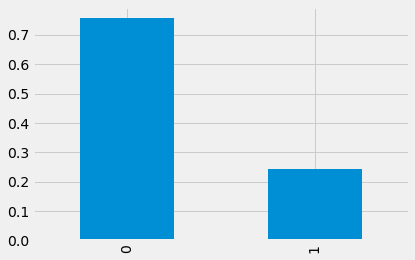

In [12]:
# balance check
print(train['TARGET'].value_counts())
train['TARGET'].value_counts(normalize=True).plot(kind='bar')

### Assessing Usefulness of New Variable with Kernel Density Estimate Plots

The kernel density estimate plot shows the distribution of a single variable (think of it as a smoothed histogram). To see the different in distributions dependent on the value of a categorical variable, we can color the distributions differently according to the category. For example, we can show the kernel density estimate of the people_counts colored by whether the TARGET = 1 or 0. The resulting KDE will show any significant differences in the distribution of the variable between damage over $\$$1,500 (TARGET == 1) and the dagmage less than $\$$1,500 (TARGET == 0). This can serve as an indicator of whether a variable will be 'relevant' to a machine learning model.

We will put this plotting functionality in a function to re-use for any variable.

In [13]:
# Plots the disribution of a variable colored by value of the target
def kde_target(var_name, df):
    
    # Calculate the correlation coefficient between the new variable and the target
    corr = df['TARGET'].corr(df[var_name])
    
    # Calculate medians for repaid vs not repaid
    avg_low_damage = df.loc[df['TARGET'] == 0, var_name].median()
    avg_high_damage = df.loc[df['TARGET'] == 1, var_name].median()
    
    plt.figure(figsize = (12, 6))
    
    # Plot the distribution for target == 0 and target == 1
    sns.kdeplot(df.loc[df['TARGET'] == 0, var_name], label = 'TARGET == 0')
    sns.kdeplot(df.loc[df['TARGET'] == 1, var_name], label = 'TARGET == 1')
    
    # label the plot
    plt.xlabel(var_name); plt.ylabel('Density'); plt.title('%s Distribution' % var_name)
    plt.legend();
    
    # print out the correlation
    print('The correlation between %s and the TARGET is %0.4f' % (var_name, corr))
    # Print out average values
    print('Median value for damage that was more than $1,500 = %0.4f' % avg_high_damage)
    print('Median value for damage that was less than $1,500= %0.4f' % avg_low_damage)

We can test this function using the ```INJURIES_TOTAL``` variable which we found to be one of the most important variables according to a Random Forest and Gradient Boosting Machine.

In [14]:
train.INJURIES_TOTAL.describe()

count    206313.000000
mean          0.172830
std           0.532269
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          21.000000
Name: INJURIES_TOTAL, dtype: float64

The correlation between INJURIES_TOTAL and the TARGET is 0.5729
Median value for damage that was more than $1,500 = 1.0000
Median value for damage that was less than $1,500= 0.0000


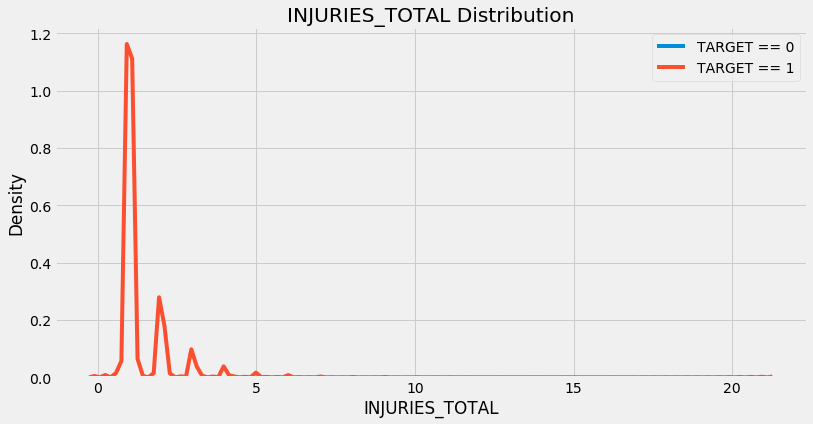

In [15]:
# INJURIES_TOTAL has lots of missing rows. To show the kde plot, I am going to impute the dataframe.


kde_target('INJURIES_TOTAL', train)

In [16]:
train['TARGET'] = train['TARGET'].astype('int')
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207101 entries, 0 to 207100
Data columns (total 50 columns):
RD_NO                            207101 non-null object
CRASH_DATE_EST_I                 13902 non-null category
CRASH_DATE                       207101 non-null datetime64[ns]
POSTED_SPEED_LIMIT               207101 non-null int64
TRAFFIC_CONTROL_DEVICE           207101 non-null category
DEVICE_CONDITION                 207101 non-null category
WEATHER_CONDITION                207101 non-null category
LIGHTING_CONDITION               207101 non-null category
FIRST_CRASH_TYPE                 207101 non-null category
TRAFFICWAY_TYPE                  207101 non-null category
LANE_CNT                         136971 non-null object
ALIGNMENT                        207101 non-null object
ROADWAY_SURFACE_COND             207101 non-null category
ROAD_DEFECT                      207101 non-null category
REPORT_TYPE                      202378 non-null category
INTERSECTION_RELATED_I 

we are dropping all of the features realatred to injury. Otherwise, there will be data leakage. 

In [18]:

drop_columns = ['MOST_SEVERE_INJURY','INJURIES_TOTAL' ,'INJURIES_FATAL', 'INJURIES_INCAPACITATING', 'INJURIES_NON_INCAPACITATING','INJURIES_REPORTED_NOT_EVIDENT','INJURIES_NO_INDICATION','INJURIES_UNKNOWN']  

train = train.drop(columns=drop_columns)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207101 entries, 0 to 207100
Data columns (total 42 columns):
RD_NO                      207101 non-null object
CRASH_DATE_EST_I           13902 non-null category
CRASH_DATE                 207101 non-null datetime64[ns]
POSTED_SPEED_LIMIT         207101 non-null int64
TRAFFIC_CONTROL_DEVICE     207101 non-null category
DEVICE_CONDITION           207101 non-null category
WEATHER_CONDITION          207101 non-null category
LIGHTING_CONDITION         207101 non-null category
FIRST_CRASH_TYPE           207101 non-null category
TRAFFICWAY_TYPE            207101 non-null category
LANE_CNT                   136971 non-null object
ALIGNMENT                  207101 non-null object
ROADWAY_SURFACE_COND       207101 non-null category
ROAD_DEFECT                207101 non-null category
REPORT_TYPE                202378 non-null category
INTERSECTION_RELATED_I     46264 non-null category
NOT_RIGHT_OF_WAY_I         9269 non-null category
HIT_AND_RUN_

+ It is obvious it is higly corelated with any features with injury columns. We might need to drop all of the injury features.

- Now for the new variable we just made, the number of people in the report.

The correlation between people_counts and the TARGET is 0.1239
Median value for damage that was more than $1,500 = 2.0000
Median value for damage that was less than $1,500= 2.0000


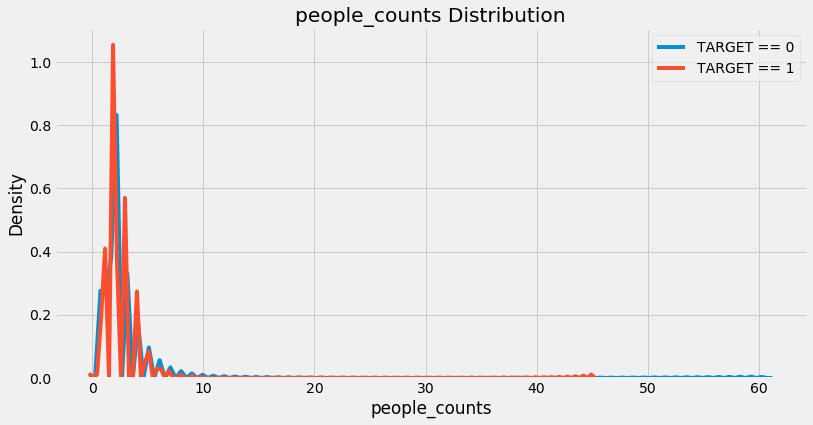

In [19]:
kde_target('people_counts', train)

+ From this it's difficult to tell if this variable will be important. 
+ Let's move on to make a few more variables from the people dataframe. We will take the mean, min, and max of every numeric column in the people dataframe.

### Aggregating Numeric Columns
To account for the numeric information in the people dataframe, we can compute statistics for all the numeric columns. 
- we ```groupby``` the client id, 
- ```agg``` the grouped dataframe, and 
- ```merge``` the result back into the training data. The ```agg``` function will only calculate the values for the numeric columns where the operation is considered valid. 
- We will stick to using ```'mean', 'max', 'min', 'sum'``` but any function can be passed in here. We can even write our own function and use it in an agg call.

In [20]:
# Group by the report number variable, AGE, BAC_RESULT VALUE calculate aggregation statistics
people_age = people.loc[:,['RD_NO','AGE']]
people_agg = people_age.groupby('RD_NO', as_index = False).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()
people_agg.head()

RD_NO   AGE                        
            count  mean   max   min   sum
0  AJ101349     1  37.0  37.0  37.0  37.0
1  AJ103671     2  19.0  38.0   0.0  38.0
2  AJ114251     2  30.0  33.0  27.0  60.0
3  AJ123519     2  43.0  58.0  28.0  86.0
4  AJ390611     0   NaN   NaN   NaN   0.0

In [21]:
# check the levels
print(people_agg.columns.levels[0])
print(people_agg.columns.levels[1])
print(people_agg.columns[0])


Index(['AGE', 'RD_NO'], dtype='object')
Index(['count', 'mean', 'max', 'min', 'sum', ''], dtype='object')
('RD_NO', '')


We need to create new names for each of these columns. The following code makes new names by appending the stat to the name. Here we have to deal with the fact that the dataframe has a multi-level index.
- I find these confusing and hard to work with, so I try to **reduce to a single level index**.

In [22]:
# List of column names
columns = ['RD_NO'] # will append from here, we need RD_NO in the list. we will use this list for column names after agg.

# Iterate through the variables names
for var in people_agg.columns.levels[0]:
    # Skip the id name
    if var != 'RD_NO': # not required, in case of numeric ID.
        
        # Iterate through the stat names
        for stat in people_agg.columns.levels[1][:-1]: # -1 there are '' at the end of level
            # Make a new column name for the variable and stat
            columns.append('people_%s_%s' % (var, stat)) # creating name of people_var_stat

In [23]:
# Assign the list of columns names as the dataframe column names, because those column names created from agg function which is not intuitive.
people_agg.columns = columns # we alreay saved column names above.
people_agg.head()

,RD_NO,people_AGE_count,people_AGE_mean,people_AGE_max,people_AGE_min,people_AGE_sum
0,AJ101349,1,37.0,37.0,37.0,37.0
1,AJ103671,2,19.0,38.0,0.0,38.0
2,AJ114251,2,30.0,33.0,27.0,60.0
3,AJ123519,2,43.0,58.0,28.0,86.0
4,AJ390611,0,NaN,NaN,NaN,0.0


In [24]:
# Merge with the training data
train = train.merge(people_agg, on = 'RD_NO', how = 'left')
train.shape

(207101, 47)

In [25]:
# check columns
columns

['RD_NO',
 'people_AGE_count',
 'people_AGE_mean',
 'people_AGE_max',
 'people_AGE_min',
 'people_AGE_sum']

### Correlations of Aggregated Values with Target
We can calculate the correlation of **all new values** with the target. 
>Again, we can use these as an approximation of the variables which may be important for modeling.

In [26]:
# List of new correlations
new_corrs = []

# Iterate through the columns 
for col in columns: # columns= ['RD_NO', 'people_AGE_count', 'people_AGE_mean', 'people_AGE_max', 'people_AGE_min', 'people_AGE_sum']
    if col !='RD_NO': # RD_NO is categorical, we need to remove this for correlations
        # Calculate correlation with the target
        corr = train['TARGET'].corr(train[col])
        # Append the list as a tuple
        new_corrs.append((col, corr))

In the code below, we sort the correlations by the magnitude (absolute value) using the sorted Python function. 
>We also make use of an anonymous lambda function, another important Python operation that is good to know.

In [27]:
# Sort the correlations by the absolute value
# Make sure to reverse to put the largest values at the front of list
new_corrs = sorted(new_corrs, key = lambda x: abs(x[1]), reverse = True)
new_corrs[:15]

[('people_AGE_count', 0.21294095385583833),
 ('people_AGE_sum', 0.16233195355156504),
 ('people_AGE_min', -0.13257419586321767),
 ('people_AGE_mean', -0.09459856336397873),
 ('people_AGE_max', -0.026686078094826766)]

**None** of the new variables have a significant correlation with the ```TARGET```. We can look at the KDE plot of the highest correlated variable with the target in in terms of absolute magnitude correlation.

The correlation between people_AGE_count and the TARGET is 0.2129
Median value for damage that was more than $1,500 = 2.0000
Median value for damage that was less than $1,500= 1.0000


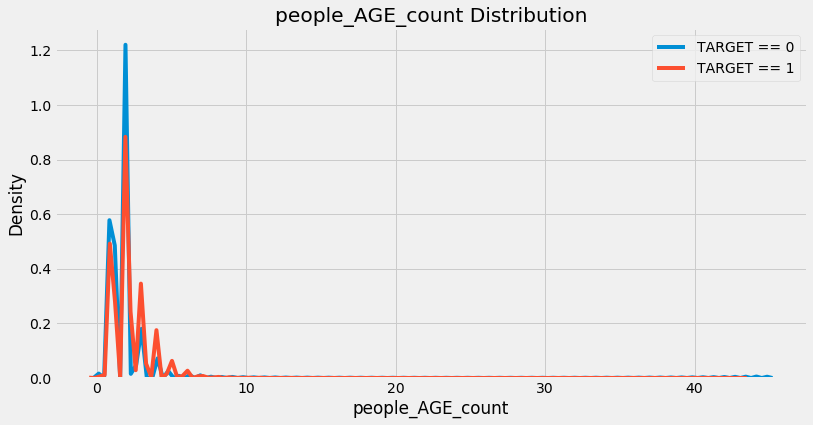

In [28]:
kde_target('people_AGE_count', train)

### The Multiple Comparisons Problem
When we have lots of variables, we expect some of them to be correlated just by pure chance, a problem known as multiple comparisons. We can make hundreds of features, and some will turn out to be corelated with the target simply because of random noise in the data. Then, when our model trains, it may overfit to these variables because it thinks they have a relationship with the target in the training set, **but this does not necessarily generalize to the test set. There are many considerations that we have to take into account when making features!**

### Correlation Function
Before we move on, we can also make the code to calculate correlations with the target into a function.

In [29]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207101 entries, 0 to 207100
Data columns (total 47 columns):
RD_NO                      207101 non-null object
CRASH_DATE_EST_I           13902 non-null category
CRASH_DATE                 207101 non-null datetime64[ns]
POSTED_SPEED_LIMIT         207101 non-null int64
TRAFFIC_CONTROL_DEVICE     207101 non-null category
DEVICE_CONDITION           207101 non-null category
WEATHER_CONDITION          207101 non-null category
LIGHTING_CONDITION         207101 non-null category
FIRST_CRASH_TYPE           207101 non-null category
TRAFFICWAY_TYPE            207101 non-null category
LANE_CNT                   136971 non-null object
ALIGNMENT                  207101 non-null object
ROADWAY_SURFACE_COND       207101 non-null category
ROAD_DEFECT                207101 non-null category
REPORT_TYPE                202378 non-null category
INTERSECTION_RELATED_I     46264 non-null category
NOT_RIGHT_OF_WAY_I         9269 non-null category
HIT_AND_RUN_

In [30]:
# will change the 
train.YEAR = train.YEAR.astype('category')
train.YEAR

0         2019
1         2019
2         2019
3         2019
4         2019
          ... 
207096    2017
207097    2017
207098    2017
207099    2017
207100    2017
Name: YEAR, Length: 207101, dtype: category
Categories (3, int64): [2017, 2018, 2019]

In [31]:
train.select_dtypes('number')

,POSTED_SPEED_LIMIT,STREET_NO,NUM_UNITS,people_counts,TARGET,people_AGE_count,people_AGE_mean,people_AGE_max,people_AGE_min,people_AGE_sum
0,30,1601,2.0,0.0,0,NaN,NaN,NaN,NaN,NaN
1,30,2859,2.0,0.0,1,NaN,NaN,NaN,NaN,NaN
2,25,3602,2.0,0.0,1,NaN,NaN,NaN,NaN,NaN
3,30,330,2.0,0.0,0,NaN,NaN,NaN,NaN,NaN
4,30,2500,2.0,0.0,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
207096,30,1601,2.0,1.0,0,1.0,20.0,20.0,20.0,20.0
207097,30,50,2.0,2.0,0,2.0,30.0,38.0,22.0,60.0
207098,35,315,2.0,2.0,0,2.0,56.0,65.0,47.0,112.0
207099,30,610,2.0,4.0,1,1.0,24.0,24.0,24.0,24.0


In [32]:
# Function to calculate correlations with the target for a dataframe
def target_corrs(df):

    # List of correlations
    corrs = []

    # Iterate through the columns 
    for col in df.columns:
        print(col)
        # Skip the target column
        if col != ['TARGET','RD_NO']:
            # Calculate correlation with the target
            corr = df['TARGET'].corr(df[col])

            # Append the list as a tuple
            corrs.append((col, corr))
            
    # Sort by absolute magnitude of correlations
    corrs = sorted(corrs, key = lambda x: abs(x[1]), reverse = True)
    
    return corrs

In [33]:
#check corrs
target_corrs(train.select_dtypes('number'))

POSTED_SPEED_LIMIT
STREET_NO
NUM_UNITS
people_counts
TARGET
people_AGE_count
people_AGE_mean
people_AGE_max
people_AGE_min
people_AGE_sum


[('TARGET', 0.9999999999999999),
 ('people_AGE_count', 0.21294095385583833),
 ('people_AGE_sum', 0.16233195355156504),
 ('people_AGE_min', -0.13257419586321767),
 ('people_counts', 0.12391415532181785),
 ('NUM_UNITS', 0.1040665484416687),
 ('POSTED_SPEED_LIMIT', 0.10359446617561072),
 ('people_AGE_mean', -0.09459856336397873),
 ('people_AGE_max', -0.026686078094826766),
 ('STREET_NO', 0.023984375636955966)]

### Categorical Variables
Now we move from the numeric columns to the categorical columns. These are discrete string variables, so we cannot just calculate statistics such as mean and max which only work with numeric variables. Instead, we will rely on calculating value counts of each category within each categorical variable.
>we will use ```'SEX','AIRBAG_DEPLOYED','SAFETY_EQUIPMENT'``` categorical variables from other tables for each Report number.
>Then we can normalize these value counts by the total number of occurences of that categorical variable for that observation (meaning that the normalized counts must sum to 1.0 for each observation).


First we ```one-hot encode``` a dataframe with only the categorical columns ```(dtype == 'object')```.

In [34]:
# Read in people_cat
people_cat = people.loc[:,['RD_NO','SEX','AIRBAG_DEPLOYED','SAFETY_EQUIPMENT']]
# We can add as many as we want. But those 3 variables looks reasonable for now.
people_cat.head()

,RD_NO,SEX,AIRBAG_DEPLOYED,SAFETY_EQUIPMENT
0,HY368708,M,NOT APPLICABLE,USAGE UNKNOWN
1,HY374018,M,DID NOT DEPLOY,SAFETY BELT USED
2,HY407431,M,DID NOT DEPLOY,USAGE UNKNOWN
3,HY484148,M,DID NOT DEPLOY,SAFETY BELT USED
4,HZ525619,X,DEPLOYMENT UNKNOWN,USAGE UNKNOWN


In [35]:
# save RD_NO to use it at merging
people1=people_cat.loc[:,['RD_NO']].copy()

In [36]:
people2 = people_cat.drop(columns='RD_NO')
categorical = pd.get_dummies(people2.select_dtypes('object'))

In [37]:
categorical['RD_NO'] = people1['RD_NO'] # adding sk_id_curr which has been set as int
categorical.head()

,SEX_F,SEX_M,SEX_U,SEX_X,"AIRBAG_DEPLOYED_DEPLOYED OTHER (KNEE, AIR, BELT, ETC.)","AIRBAG_DEPLOYED_DEPLOYED, COMBINATION","AIRBAG_DEPLOYED_DEPLOYED, FRONT","AIRBAG_DEPLOYED_DEPLOYED, SIDE",AIRBAG_DEPLOYED_DEPLOYMENT UNKNOWN,AIRBAG_DEPLOYED_DID NOT DEPLOY,...,SAFETY_EQUIPMENT_CHILD RESTRAINT NOT USED,SAFETY_EQUIPMENT_CHILD RESTRAINT USED,SAFETY_EQUIPMENT_CHILD RESTRAINT USED IMPROPERLY,SAFETY_EQUIPMENT_HELMET NOT USED,SAFETY_EQUIPMENT_HELMET USED,SAFETY_EQUIPMENT_NONE PRESENT,SAFETY_EQUIPMENT_SAFETY BELT NOT USED,SAFETY_EQUIPMENT_SAFETY BELT USED,SAFETY_EQUIPMENT_USAGE UNKNOWN,RD_NO
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,HY368708
1,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,HY374018
2,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,HY407431
3,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,HY484148
4,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,HZ525619


In [38]:
categorical_grouped = categorical.groupby('RD_NO').agg(['sum', 'mean']) # after changed to dummies we can agg.
categorical_grouped.head()

SEX_F           SEX_M           SEX_U      SEX_X            \
           sum      mean   sum      mean   sum mean   sum      mean   
RD_NO                                                                 
AJ101349     2  1.000000     0  0.000000     0  0.0     0  0.000000   
AJ103671     1  0.333333     1  0.333333     0  0.0     1  0.333333   
AJ114251     0  0.000000     2  1.000000     0  0.0     0  0.000000   
AJ123519     0  0.000000     2  1.000000     0  0.0     0  0.000000   
AJ390611     0  0.000000     0  0.000000     0  0.0     1  1.000000   

         AIRBAG_DEPLOYED_DEPLOYED OTHER (KNEE, AIR, BELT, ETC.)       ...  \
                                                            sum mean  ...   
RD_NO                                                                 ...   
AJ101349                                                  0      0.0  ...   
AJ103671                                                  0      0.0  ...   
AJ114251                                                  0      0.0  ...   
AJ123519                                                  0      0.0  ...   
AJ390611                                                  0      0.0  ...   

         SAFETY_EQUIPMENT_HELMET USED      SAFETY_EQUIPMENT_NONE PRESENT       \
                                  sum mean                           sum mean   
RD_NO                                                                           
AJ101349                            0  0.0                             1  0.5   
AJ103671                            0  0.0                             0  0.0   
AJ114251                            0  0.0                             0  0.0   
AJ123519                            0  0.0                             0  0.0   
AJ390611                            0  0.0                             0  0.0   

         SAFETY_EQUIPMENT_SAFETY BELT NOT USED       \
                                           sum mean   
RD_NO                                                 
AJ101349                                     0  0.0   
AJ103671                                     0  0.0   
AJ114251                                     0  0.0   
AJ123519                                     0  0.0   
AJ390611                                     0  0.0   

         SAFETY_EQUIPMENT_SAFETY BELT USED            \
                                       sum      mean   
RD_NO                                                  
AJ101349                                 1  0.500000   
AJ103671                                 1  0.333333   
AJ114251                                 0  0.000000   
AJ123519                                 1  0.500000   
AJ390611                                 0  0.000000   

         SAFETY_EQUIPMENT_USAGE UNKNOWN            
                                    sum      mean  
RD_NO                                              
AJ101349                              0  0.000000  
AJ103671                              1  0.333333  
AJ114251                              2  1.000000  
AJ123519                              1  0.500000  
AJ390611                              1  1.000000  

[5 rows x 40 columns]

- The ```sum``` columns represent the count of that category for the associated report number.
- The ```mean``` represents the normalized count. 
>One-hot encoding makes the process of calculating these figures very easy!

We can use a similar function as before to rename the columns. 
>Again, we have to deal with the multi-level index for the columns. We iterate through the first level (level 0) which is the name of the categorical variable appended with the value of the category (from one-hot encoding). Then we iterate stats we calculated for each client. We will rename the column with the level 0 name appended with the stat. 
>>As an example, the column with SEX_F_count as level 0. 
>>and sum as level 1 will become SEX_F_count.

In [39]:
group_var = 'RD_NO'

# Need to create new column names
columns = []

# Iterate through the variables names
for var in categorical_grouped.columns.levels[0]:
    # Skip the grouping variable
    if var != group_var:
        # Iterate through the stat names
        for stat in ['count', 'count_norm']:# sum-> count, mean->count_norm
            # Make a new column name for the variable and stat
            columns.append('%s_%s' % (var, stat))

#  Rename the columns
categorical_grouped.columns = columns

categorical_grouped.head()

,SEX_F_count,SEX_F_count_norm,SEX_M_count,SEX_M_count_norm,SEX_U_count,SEX_U_count_norm,SEX_X_count,SEX_X_count_norm,"AIRBAG_DEPLOYED_DEPLOYED OTHER (KNEE, AIR, BELT, ETC.)_count","AIRBAG_DEPLOYED_DEPLOYED OTHER (KNEE, AIR, BELT, ETC.)_count_norm",...,SAFETY_EQUIPMENT_HELMET USED_count,SAFETY_EQUIPMENT_HELMET USED_count_norm,SAFETY_EQUIPMENT_NONE PRESENT_count,SAFETY_EQUIPMENT_NONE PRESENT_count_norm,SAFETY_EQUIPMENT_SAFETY BELT NOT USED_count,SAFETY_EQUIPMENT_SAFETY BELT NOT USED_count_norm,SAFETY_EQUIPMENT_SAFETY BELT USED_count,SAFETY_EQUIPMENT_SAFETY BELT USED_count_norm,SAFETY_EQUIPMENT_USAGE UNKNOWN_count,SAFETY_EQUIPMENT_USAGE UNKNOWN_count_norm
RD_NO,,,,,,,,,,,,,,,,,,,,,
AJ101349,2,1.000000,0,0.000000,0,0.0,0,0.000000,0,0.0,...,0,0.0,1,0.5,0,0.0,1,0.500000,0,0.000000
AJ103671,1,0.333333,1,0.333333,0,0.0,1,0.333333,0,0.0,...,0,0.0,0,0.0,0,0.0,1,0.333333,1,0.333333
AJ114251,0,0.000000,2,1.000000,0,0.0,0,0.000000,0,0.0,...,0,0.0,0,0.0,0,0.0,0,0.000000,2,1.000000
AJ123519,0,0.000000,2,1.000000,0,0.0,0,0.000000,0,0.0,...,0,0.0,0,0.0,0,0.0,1,0.500000,1,0.500000
AJ390611,0,0.000000,0,0.000000,0,0.0,1,1.000000,0,0.0,...,0,0.0,0,0.0,0,0.0,0,0.000000,1,1.000000


The sum column records the counts and the mean column records the normalized count.
We can merge this dataframe into the training data.

In [40]:
train = train.merge(categorical_grouped, left_on = 'RD_NO', right_index = True, how = 'left')
train.head()

,RD_NO,CRASH_DATE_EST_I,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,...,SAFETY_EQUIPMENT_HELMET USED_count,SAFETY_EQUIPMENT_HELMET USED_count_norm,SAFETY_EQUIPMENT_NONE PRESENT_count,SAFETY_EQUIPMENT_NONE PRESENT_count_norm,SAFETY_EQUIPMENT_SAFETY BELT NOT USED_count,SAFETY_EQUIPMENT_SAFETY BELT NOT USED_count_norm,SAFETY_EQUIPMENT_SAFETY BELT USED_count,SAFETY_EQUIPMENT_SAFETY BELT USED_count_norm,SAFETY_EQUIPMENT_USAGE UNKNOWN_count,SAFETY_EQUIPMENT_USAGE UNKNOWN_count_norm
0,JC123097,NaN,2019-01-19 23:45:00,30,TRAFFIC SIGNAL,UNKNOWN,SNOW,"DARKNESS, LIGHTED ROAD",REAR END,DIVIDED - W/MEDIAN (NOT RAISED),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,JC123084,NaN,2019-01-19 23:30:00,30,NO CONTROLS,NO CONTROLS,SNOW,"DARKNESS, LIGHTED ROAD",PEDALCYCLIST,NOT DIVIDED,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,JC123076,NaN,2019-01-19 23:16:00,25,STOP SIGN/FLASHER,FUNCTIONING PROPERLY,SNOW,"DARKNESS, LIGHTED ROAD",ANGLE,DIVIDED - W/MEDIAN (NOT RAISED),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,JC123075,NaN,2019-01-19 23:15:00,30,NO CONTROLS,NO CONTROLS,SNOW,"DARKNESS, LIGHTED ROAD",SIDESWIPE SAME DIRECTION,DIVIDED - W/MEDIAN BARRIER,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,JC123050,Y,2019-01-19 22:52:00,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,SNOW,"DARKNESS, LIGHTED ROAD",REAR END,NOT DIVIDED,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Vehicle data
Let us check vehicle data to agg some features. ['MANEUVER','FIRST_CONTACT_POINT','VEHICLE_TYPE'] variables sounds interesting to agg and merge. 

In [41]:
vehicle = pd.read_csv('../input/Traffic_Crashes_-_Vehicles.csv')

vehicle1 = vehicle.loc[:,['MANEUVER','FIRST_CONTACT_POINT','VEHICLE_TYPE'] ]


#### Function to Handle Categorical Variables
To make the code more efficient, we can now write a function to handle the categorical variables for us. This will take the same form as the agg_numeric function in that it accepts a dataframe and a grouping variable. Then it will calculate the counts and normalized counts of each category for all categorical variables in the dataframe.

In [42]:
def count_categorical(df, df1, group_var, df_name):
    """Computes counts and normalized counts for each observation
    of `group_var` of each unique category in every categorical variable
    
    Parameters
    --------
    df : dataframe 
        The dataframe to calculate the value counts for.
    
    df1: datafrae
        The dataframe to add ID feature
        
    group_var : string
        The variable by which to group the dataframe. For each unique
        value of this variable, the final dataframe will have one row
        
    df_name : string
        Variable added to the front of column names to keep track of columns

    
    Return
    --------
    categorical : dataframe
        A dataframe with counts and normalized counts of each unique category in every categorical variable
        with one row for every unique value of the `group_var`.
        
    """
    
    # Select the categorical columns
    categorical = pd.get_dummies(df.select_dtypes('object'))

    # Make sure to put the identifying id on the column
    categorical[group_var] = df1[group_var]

    # Groupby the group var and calculate the sum and mean
    categorical = categorical.groupby(group_var).agg(['sum', 'mean'])
    
    column_names = []
    
    # Iterate through the columns in level 0
    for var in categorical.columns.levels[0]:
        # Iterate through the stats in level 1
        for stat in ['count', 'count_norm']:
            # Make a new column name
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
    
    return categorical

In [43]:
vehicle_counts = count_categorical(vehicle1,vehicle, group_var = 'RD_NO', df_name = 'vehicle')
vehicle_counts.head()

,vehicle_MANEUVER_AVOIDING VEHICLES/OBJECTS_count,vehicle_MANEUVER_AVOIDING VEHICLES/OBJECTS_count_norm,vehicle_MANEUVER_BACKING_count,vehicle_MANEUVER_BACKING_count_norm,vehicle_MANEUVER_CHANGING LANES_count,vehicle_MANEUVER_CHANGING LANES_count_norm,vehicle_MANEUVER_DIVERGING_count,vehicle_MANEUVER_DIVERGING_count_norm,vehicle_MANEUVER_DRIVERLESS_count,vehicle_MANEUVER_DRIVERLESS_count_norm,...,vehicle_VEHICLE_TYPE_TRACTOR W/ SEMI-TRAILER_count,vehicle_VEHICLE_TYPE_TRACTOR W/ SEMI-TRAILER_count_norm,vehicle_VEHICLE_TYPE_TRACTOR W/O SEMI-TRAILER_count,vehicle_VEHICLE_TYPE_TRACTOR W/O SEMI-TRAILER_count_norm,vehicle_VEHICLE_TYPE_TRUCK - SINGLE UNIT_count,vehicle_VEHICLE_TYPE_TRUCK - SINGLE UNIT_count_norm,vehicle_VEHICLE_TYPE_UNKNOWN/NA_count,vehicle_VEHICLE_TYPE_UNKNOWN/NA_count_norm,vehicle_VEHICLE_TYPE_VAN/MINI-VAN_count,vehicle_VEHICLE_TYPE_VAN/MINI-VAN_count_norm
RD_NO,,,,,,,,,,,,,,,,,,,,,
AJ101349,0,0.0,0,0.0,1,0.5,0,0.0,0,0.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
AJ103671,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
AJ114251,0,0.0,0,0.0,1,0.5,0,0.0,0,0.0,...,1,0.5,0,0.0,1,0.5,0,0.0,0,0.0
AJ123519,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,...,0,0.0,0,0.0,0,0.0,0,0.0,1,0.5
AJ390611,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,...,0,0.0,0,0.0,0,0.0,1,0.5,0,0.0


In [44]:
train = train.merge(vehicle_counts, left_on = 'RD_NO', right_index = True, how = 'left')
train.head()

,RD_NO,CRASH_DATE_EST_I,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,...,vehicle_VEHICLE_TYPE_TRACTOR W/ SEMI-TRAILER_count,vehicle_VEHICLE_TYPE_TRACTOR W/ SEMI-TRAILER_count_norm,vehicle_VEHICLE_TYPE_TRACTOR W/O SEMI-TRAILER_count,vehicle_VEHICLE_TYPE_TRACTOR W/O SEMI-TRAILER_count_norm,vehicle_VEHICLE_TYPE_TRUCK - SINGLE UNIT_count,vehicle_VEHICLE_TYPE_TRUCK - SINGLE UNIT_count_norm,vehicle_VEHICLE_TYPE_UNKNOWN/NA_count,vehicle_VEHICLE_TYPE_UNKNOWN/NA_count_norm,vehicle_VEHICLE_TYPE_VAN/MINI-VAN_count,vehicle_VEHICLE_TYPE_VAN/MINI-VAN_count_norm
0,JC123097,NaN,2019-01-19 23:45:00,30,TRAFFIC SIGNAL,UNKNOWN,SNOW,"DARKNESS, LIGHTED ROAD",REAR END,DIVIDED - W/MEDIAN (NOT RAISED),...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,JC123084,NaN,2019-01-19 23:30:00,30,NO CONTROLS,NO CONTROLS,SNOW,"DARKNESS, LIGHTED ROAD",PEDALCYCLIST,NOT DIVIDED,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.5,0.0,0.0
2,JC123076,NaN,2019-01-19 23:16:00,25,STOP SIGN/FLASHER,FUNCTIONING PROPERLY,SNOW,"DARKNESS, LIGHTED ROAD",ANGLE,DIVIDED - W/MEDIAN (NOT RAISED),...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,JC123075,NaN,2019-01-19 23:15:00,30,NO CONTROLS,NO CONTROLS,SNOW,"DARKNESS, LIGHTED ROAD",SIDESWIPE SAME DIRECTION,DIVIDED - W/MEDIAN BARRIER,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.5
4,JC123050,Y,2019-01-19 22:52:00,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,SNOW,"DARKNESS, LIGHTED ROAD",REAR END,NOT DIVIDED,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Insert Computed Features into Training Data

In [45]:
new_features = list(train.columns)
print('Number of features using people: ', len(new_features))

Number of features using people:  205


## Feature Engineering Outcomes
After all that work, now we want to take a look at the variables we have created. 
1. We can look at the percentage of missing values, 
1. the correlations of variables with the target, 
1. and also the correlation of variables with the other variables. 

>The correlations between variables can show if we have collinear varibles, that is, variables that are highly correlated with one another. Often, we want to remove one in a pair of collinear variables because having both variables would be redundant.

>We can also use the percentage of missing values to remove features with a substantial majority of values that are not present.

- Feature selection will be an important focus going forward, because reducing the number of features can help the model learn during training and also generalize better to the testing data. 
>The "curse of dimensionality" is the name given to the issues caused by having too many features (too high of a dimension). As the number of variables increases, the number of datapoints needed to learn the relationship between these variables and the target value increases exponentially.

- Feature selection is the process of removing variables to help our model to learn and generalize better to the testing set. The objective is to remove useless/redundant variables while preserving those that are useful. There are a number of tools we can use for this process, but in this notebook we will stick to...

> 1. removing columns with a high percentage of missing values 
> 2. and variables that have a high correlation with one another. 

Later we can look at using the feature importances returned from models such as the Gradient Boosting Machine or Random Forest to perform feature selection.

### Missing Values
An important consideration is the missing values in the dataframe. Columns with too many missing values might have to be dropped.

In [46]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [47]:
missing_train = missing_values_table(train)

Your selected dataframe has 205 columns.
There are 180 columns that have missing values.


In [48]:
missing_train.head(10)

,Missing Values,% of Total Values
WORKERS_PRESENT_I,206730,99.8
DOORING_I,206359,99.6
WORK_ZONE_TYPE,205815,99.4
WORK_ZONE_I,205500,99.2
PHOTOS_TAKEN_I,204528,98.8
STATEMENTS_TAKEN_I,202576,97.8
NOT_RIGHT_OF_WAY_I,197832,95.5
CRASH_DATE_EST_I,193199,93.3
INTERSECTION_RELATED_I,160837,77.7
HIT_AND_RUN_I,149672,72.3


We see there are a number of columns with a high percentage of missing values. There is no well-established threshold for removing missing values, and the best course of action depends on the problem. Here, to reduce the number of features, we will remove any columns in either the training or the testing data that have greater than 70% missing values.

In [49]:
missing_train_vars = list(missing_train.index[missing_train['% of Total Values'] > 70])
len(missing_train_vars)

10

In [50]:
# Drop the missing columns
missing_columns = list(missing_train_vars)
print('There are %d columns with more than 90%% missing in the dataframe.' % len(missing_columns))

train = train.drop(columns = missing_columns)

There are 10 columns with more than 90% missing in the dataframe.


We ended up removing 8 columns. We might have to apply another feature selection method to reduce the dimensionality.



In [51]:
train.to_csv('../input/00_injury_train_people_vehicle_missing_70.csv', index = False)

### Correlations
First let's look at the correlations of the variables with the target. We can see in any of the variables we created have a greater correlation than those already present in the training data.

In [52]:
# Calculate all correlations in dataframe
corrs = train.corr()

In [53]:
corrs = corrs.sort_values('TARGET', ascending = False)

# Ten most positive correlations
pd.DataFrame(corrs['TARGET'].head(10))

,TARGET
TARGET,1.000000
"AIRBAG_DEPLOYED_DEPLOYED, FRONT_count_norm",0.300210
"AIRBAG_DEPLOYED_DEPLOYED, FRONT_count",0.298171
"AIRBAG_DEPLOYED_DEPLOYED, COMBINATION_count_norm",0.223687
people_AGE_count,0.212941
"AIRBAG_DEPLOYED_DEPLOYED, COMBINATION_count",0.208074
vehicle_FIRST_CONTACT_POINT_FRONT_count,0.170930
vehicle_FIRST_CONTACT_POINT_FRONT_count_norm,0.170642
people_AGE_sum,0.162332
"AIRBAG_DEPLOYED_DEPLOYED, SIDE_count_norm",0.140062


In [54]:
# Ten most negative correlations
pd.DataFrame(corrs['TARGET'].dropna().tail(10))

,TARGET
SEX_X_count_norm,-0.104671
vehicle_FIRST_CONTACT_POINT_UNKNOWN_count,-0.119175
vehicle_VEHICLE_TYPE_UNKNOWN/NA_count,-0.119476
AIRBAG_DEPLOYED_DID NOT DEPLOY_count_norm,-0.120341
vehicle_FIRST_CONTACT_POINT_UNKNOWN_count_norm,-0.120439
vehicle_MANEUVER_BACKING_count_norm,-0.126526
vehicle_VEHICLE_TYPE_UNKNOWN/NA_count_norm,-0.126764
vehicle_MANEUVER_BACKING_count,-0.128555
people_AGE_min,-0.132574
AIRBAG_DEPLOYED_DEPLOYMENT UNKNOWN_count_norm,-0.133760


The highest correlated variable with the target is a variable we created. However, just because the variable is correlated does not mean that it will be useful, and we have to remember that if we generate hundreds of new variables, some are going to be correlated with the target simply because of random noise.

Viewing the correlations skeptically, it does appear that several of the newly created variables may be useful. To assess the "usefulness" of variables, we will look at the feature importances returned by the model. For curiousity's sake (and because we already wrote the function) we can make a kde plot of two of the newly created variables.

The correlation between AIRBAG_DEPLOYED_DEPLOYED, FRONT_count_norm and the TARGET is 0.3002
Median value for damage that was more than $1,500 = 0.0000
Median value for damage that was less than $1,500= 0.0000


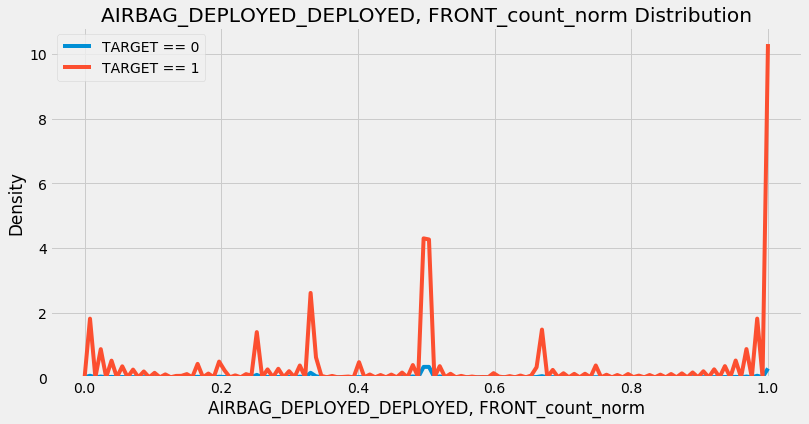

In [55]:
kde_target(var_name='AIRBAG_DEPLOYED_DEPLOYED, FRONT_count_norm', df=train)

FRONT_count_norm means = 0.5 means Airbag_deployed_front is 50% of all of airbag deployed. 

### Collinear Variables
We can calculate not only the correlations of the variables with the target, but also the correlation of each variable with every other variable. This will allow us to see if there are highly collinear variables that should perhaps be removed from the data.

Let's look for any variables that have a greather than 0.8 correlation with other variables.

In [56]:
# Set the threshold
threshold = 0.8

# Empty dictionary to hold correlated variables
above_threshold_vars = {}

# For each column, record the variables that are above the threshold
for col in corrs:
    above_threshold_vars[col] = list(corrs.index[corrs[col] > threshold])

For each of these pairs of highly correlated variables, we only want to remove one of the variables. The following code creates a set of variables to remove by only adding one of each pair.

In [57]:
# Track columns to remove and columns already examined
cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []

# Iterate through columns and correlated columns
for key, value in above_threshold_vars.items():
    # Keep track of columns already examined
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else:
            # Only want to remove one in a pair
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)
            
cols_to_remove = list(set(cols_to_remove))
print('Number of columns to remove: ', len(cols_to_remove))

Number of columns to remove:  73


We will have to compare performance after removing these variables with performance keeping these variables (the raw csv files we saved earlier).


In [58]:
train_corrs_removed = train.drop(columns = cols_to_remove)
print('Training Corrs Removed Shape: ', train_corrs_removed.shape)

Training Corrs Removed Shape:  (207101, 122)


In [59]:
train_corrs_removed.to_csv('../input/00_injury_train_people_vehicle_corrs_removed.csv', index = False)